In [3]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [4]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [5]:
# Loading the dataset and preparing it for training
train_path = '../dataset_organized/train/'
test_path = '../dataset_organized/test/'
val_path = '../dataset_organized/validation/'

# Loading the dataset
import os
import cv2
from tqdm import tqdm

def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)
X_val, y_val = load_images(val_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# One hot encoding the target variable
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)
y_val = to_categorical(y_val_encoded)

# Splitting the training set into training and validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 17/17 [00:00<00:00, 898.53it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,126 (56.39 MB)

 Trainable params: 66,438 (259.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


2025-04-02 15:19:40.152713: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 477360000 exceeds 10% of free system memory.
2025-04-02 15:19:42.844897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-04-02 15:19:42.926497: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


 1/56 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.2812 - loss: 2.0294

2025-04-02 15:19:44.332305: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-04-02 15:19:44.375362: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3080 - loss: 1.7222 - val_accuracy: 0.5061 - val_loss: 1.3299
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 917ms/step - accuracy: 0.5290 - loss: 1.2804 - val_accuracy: 0.5671 - val_loss: 1.1353
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 938ms/step - accuracy: 0.5756 - loss: 1.1321 - val_accuracy: 0.6159 - val_loss: 1.0472
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 934ms/step - accuracy: 0.5998 - loss: 1.0414 - val_accuracy: 0.6433 - val_loss: 0.9707
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 907ms/step - accuracy: 0.6385 - loss: 0.9913 - val_accuracy: 0.6585 - val_loss: 0.9189
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 906ms/step - accuracy: 0.6406 - loss: 0.9216 - val_accuracy: 0.6646 - val_loss: 0.8869
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 905ms/step - accuracy: 0.6857 - loss: 0.8860 - val_accuracy: 0.6860 - val_loss: 0.8567
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 949ms/step - accuracy: 0.6941 - loss: 0.8638 - val_accuracy: 0.7104 -

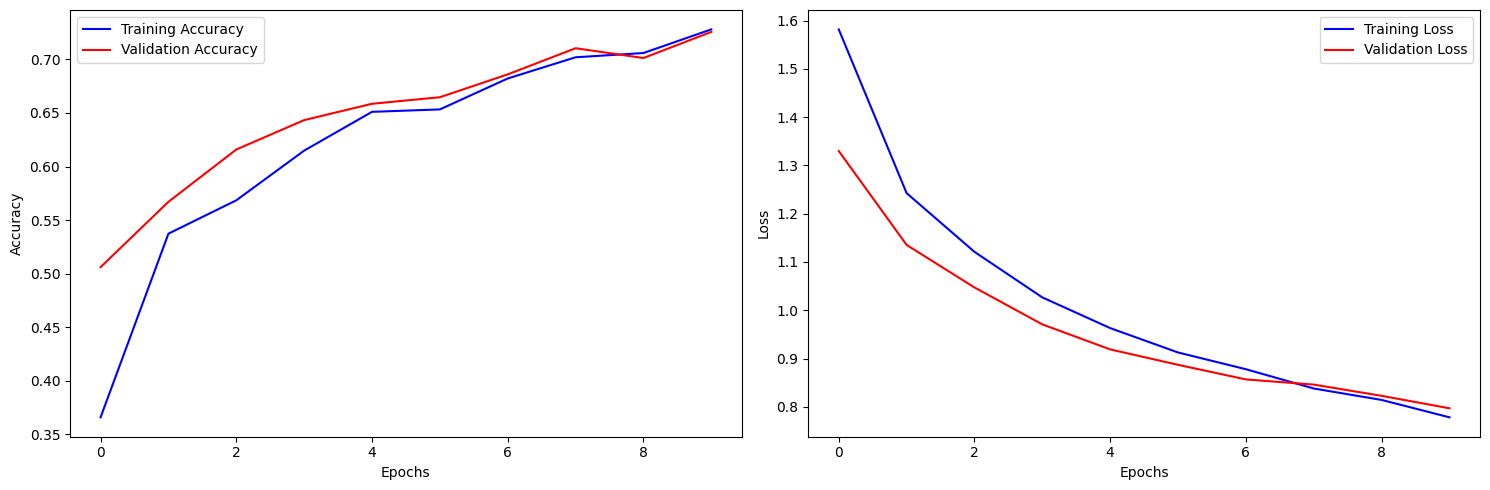

Training Accuracy: 0.7279411554336548
Validation Accuracy: 0.7256097793579102
Training Loss: 0.778128981590271
Validation Loss: 0.7968519926071167


In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('vgg_model.h5')
plt.figure(figsize=(15, 5))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()



print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])

print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])

# Building the VGG16 model with L2 Regularization


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 938ms/step - accuracy: 0.3124 - loss: 1.8095 - val_accuracy: 0.5549 - val_loss: 1.3725
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 919ms/step - accuracy: 0.5947 - loss: 1.2602 - val_accuracy: 0.5427 - val_loss: 1.2089
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 915ms/step - accuracy: 0.6304 - loss: 1.1052 - val_accuracy: 0.6494 - val_loss: 1.0870
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 920ms/step - accuracy: 0.7055 - loss: 0.9672 - val_accuracy: 0.6646 - val_loss: 1.0227
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 916ms/step - accuracy: 0.7110 - loss: 0.9179 - val_accuracy: 0.6921 - val_loss: 0.9749
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 920ms/step - accuracy: 0.7294 - loss: 0.8922 - val_accuracy: 0.7134 - val_loss: 0.9616
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 921ms/step - accuracy: 0.7537 - loss: 0.8118 - val_accuracy: 0.6616 - val_loss: 0.9784
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 922ms/step - accuracy: 0.7555 - loss: 0.8281 - val_accu

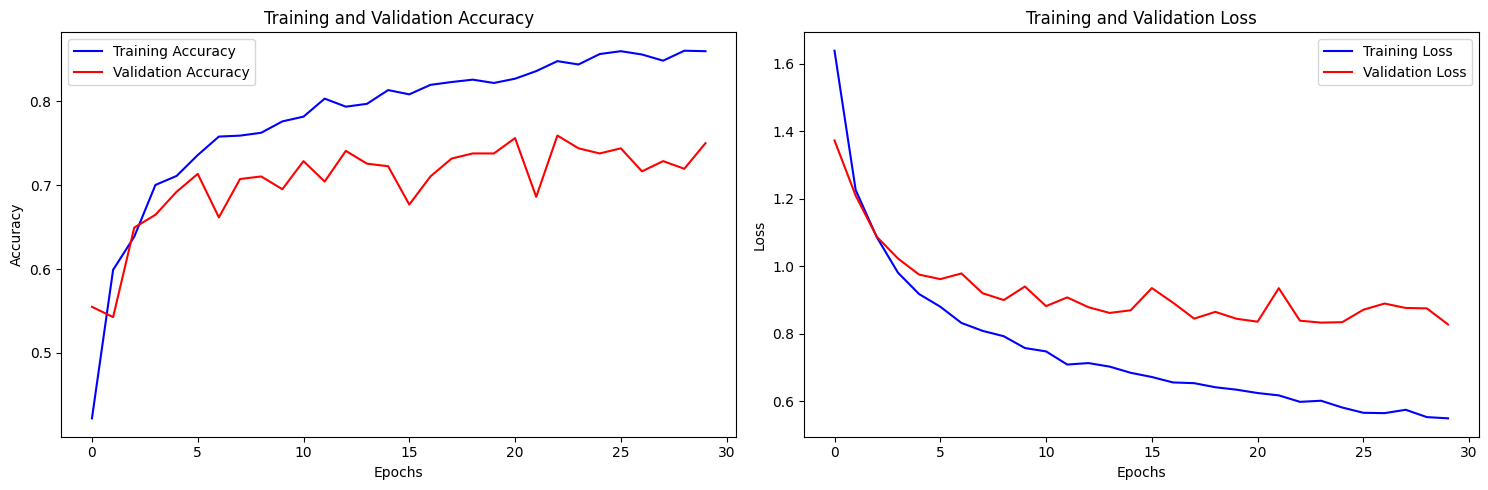

Training Accuracy: 0.8597285151481628
Validation Accuracy: 0.75
Training Loss: 0.5491123199462891
Validation Loss: 0.827232837677002


In [7]:
from keras.regularizers import l2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('vgg_model_l2.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the VGG16 model with L1 Regularization


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 934ms/step - accuracy: 0.3255 - loss: 4.2943 - val_accuracy: 0.5335 - val_loss: 2.6349
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 923ms/step - accuracy: 0.5550 - loss: 2.3172 - val_accuracy: 0.5000 - val_loss: 1.8884
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 923ms/step - accuracy: 0.5885 - loss: 1.7628 - val_accuracy: 0.5823 - val_loss: 1.6329
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 922ms/step - accuracy: 0.6383 - loss: 1.5038 - val_accuracy: 0.6067 - val_loss: 1.4699
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 920ms/step - accuracy: 0.6689 - loss: 1.4052 - val_accuracy: 0.6280 - val_loss: 1.4098
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 891ms/step - accuracy: 0.6291 - loss: 1.3869 - val_accuracy: 0.6098 - val_loss: 1.3842
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 928ms/step - accuracy: 0.6515 - loss: 1.2806 - val_accuracy: 0.5884 - val_loss: 1.3556
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 870ms/step - accuracy: 0.6604 - loss: 1.3091 - val_accu

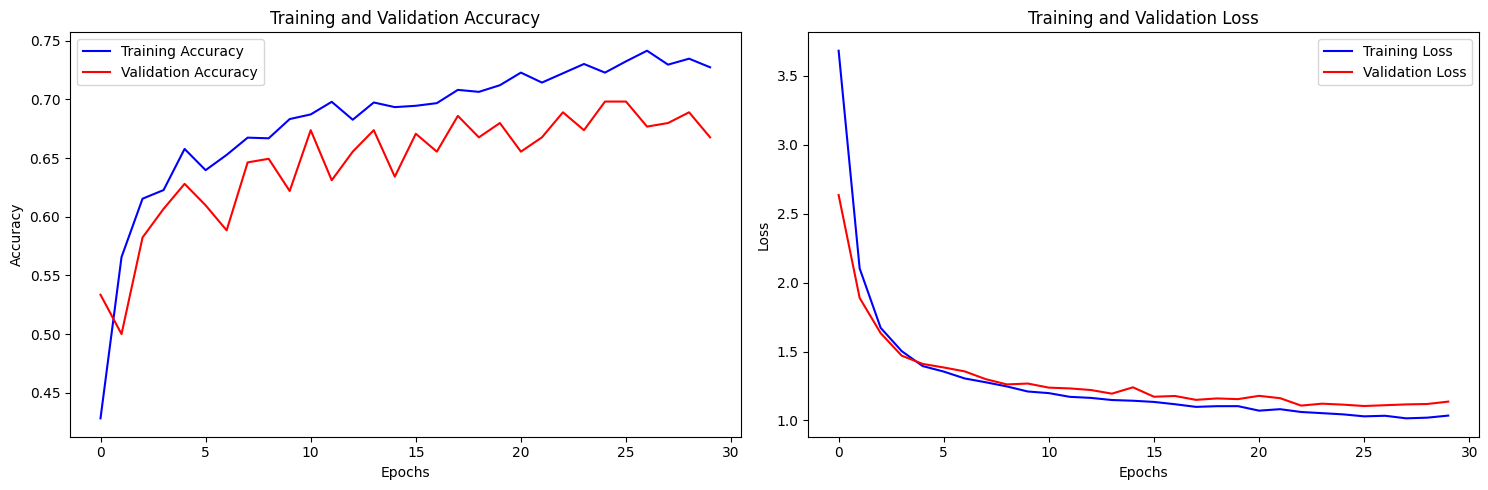

Training Accuracy: 0.7273755669593811
Validation Accuracy: 0.667682945728302
Training Loss: 1.0351359844207764
Validation Loss: 1.1365994215011597


In [8]:
from keras.regularizers import l1

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('vgg_model_l1.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the VGG16 model with Dropout Regularization


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 938ms/step - accuracy: 0.2606 - loss: 1.7993 - val_accuracy: 0.5213 - val_loss: 1.3218
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 960ms/step - accuracy: 0.5134 - loss: 1.3141 - val_accuracy: 0.5610 - val_loss: 1.1446
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 916ms/step - accuracy: 0.5885 - loss: 1.1267 - val_accuracy: 0.6159 - val_loss: 1.0574
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 924ms/step - accuracy: 0.5916 - loss: 1.0716 - val_accuracy: 0.6189 - val_loss: 0.9955
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 930ms/step - accuracy: 0.6294 - loss: 0.9860 - val_accuracy: 0.6677 - val_loss: 0.9357
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 922ms/step - accuracy: 0.6669 - loss: 0.9042 - val_accuracy: 0.6402 - val_loss: 0.9302
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 925ms/step - accuracy: 0.6892 - loss: 0.8620 - val_accuracy: 0.6829 - val_loss: 0.8554
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 929ms/step - accuracy: 0.7123 - loss: 0.8520 - val_accu

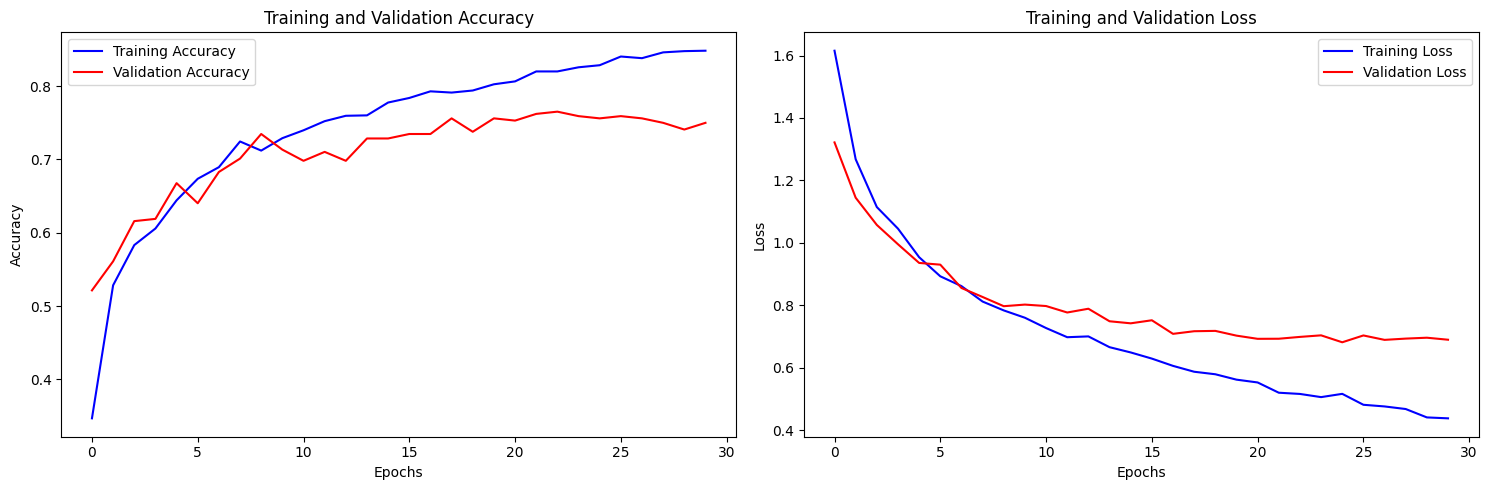

Training Accuracy: 0.848416268825531
Validation Accuracy: 0.75
Training Loss: 0.43783408403396606
Validation Loss: 0.6896919012069702


In [9]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('vgg_model_dropout.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


In [10]:
# Building the VGG16 model with EarlyStopping


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 913ms/step - accuracy: 0.3396 - loss: 1.6259 - val_accuracy: 0.5854 - val_loss: 1.2015
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 913ms/step - accuracy: 0.6111 - loss: 1.0977 - val_accuracy: 0.5854 - val_loss: 1.0699
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 910ms/step - accuracy: 0.6459 - loss: 0.9717 - val_accuracy: 0.6463 - val_loss: 0.9567
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 917ms/step - accuracy: 0.6970 - loss: 0.8571 - val_accuracy: 0.6738 - val_loss: 0.9010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 911ms/step - accuracy: 0.7234 - loss: 0.8126 - val_accuracy: 0.7256 - val_loss: 0.8402
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 901ms/step - accuracy: 0.7645 - loss: 0.7341 - val_accuracy: 0.7226 - val_loss: 0.8169
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 880ms/step - accuracy: 0.7808 - loss: 0.6591 - val_accuracy: 0.7287 - val_loss: 0.8109
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 883ms/step - accuracy: 0.7603 - loss: 0.6850 - val_accu

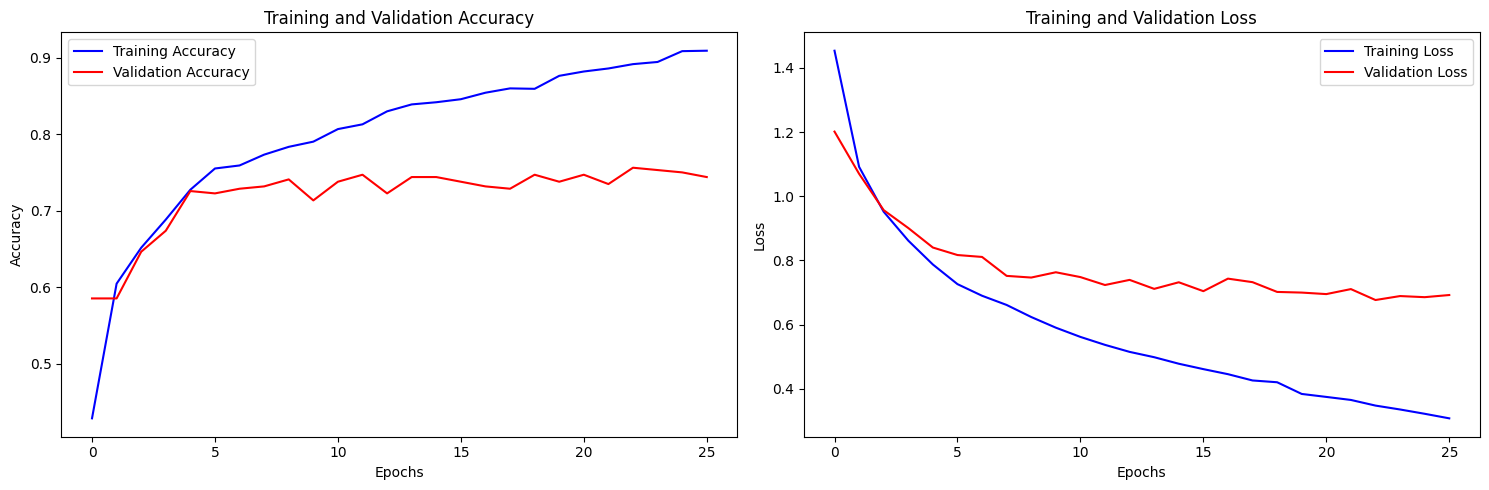

Training Accuracy: 0.9089366793632507
Validation Accuracy: 0.7439024448394775
Training Loss: 0.3079473376274109
Validation Loss: 0.6922211050987244


In [11]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Saving the model
model.save('vgg_model_es.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the VGG16 model with Dropout + EarlyStopping


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 875ms/step - accuracy: 0.2561 - loss: 1.8187 - val_accuracy: 0.4970 - val_loss: 1.3500
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 878ms/step - accuracy: 0.5062 - loss: 1.2934 - val_accuracy: 0.5488 - val_loss: 1.1599
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 874ms/step - accuracy: 0.5350 - loss: 1.1831 - val_accuracy: 0.5793 - val_loss: 1.0625
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 923ms/step - accuracy: 0.6311 - loss: 1.0129 - val_accuracy: 0.6463 - val_loss: 0.9891
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 869ms/step - accuracy: 0.6401 - loss: 0.9544 - val_accuracy: 0.6799 - val_loss: 0.9346
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 876ms/step - accuracy: 0.6492 - loss: 0.9400 - val_accuracy: 0.6860 - val_loss: 0.8943
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 925ms/step - accuracy: 0.6714 - loss: 0.8946 - val_accuracy: 0.6860 - val_loss: 0.8741
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 868ms/step - accuracy: 0.7127 - loss: 0.8168 - val_accu

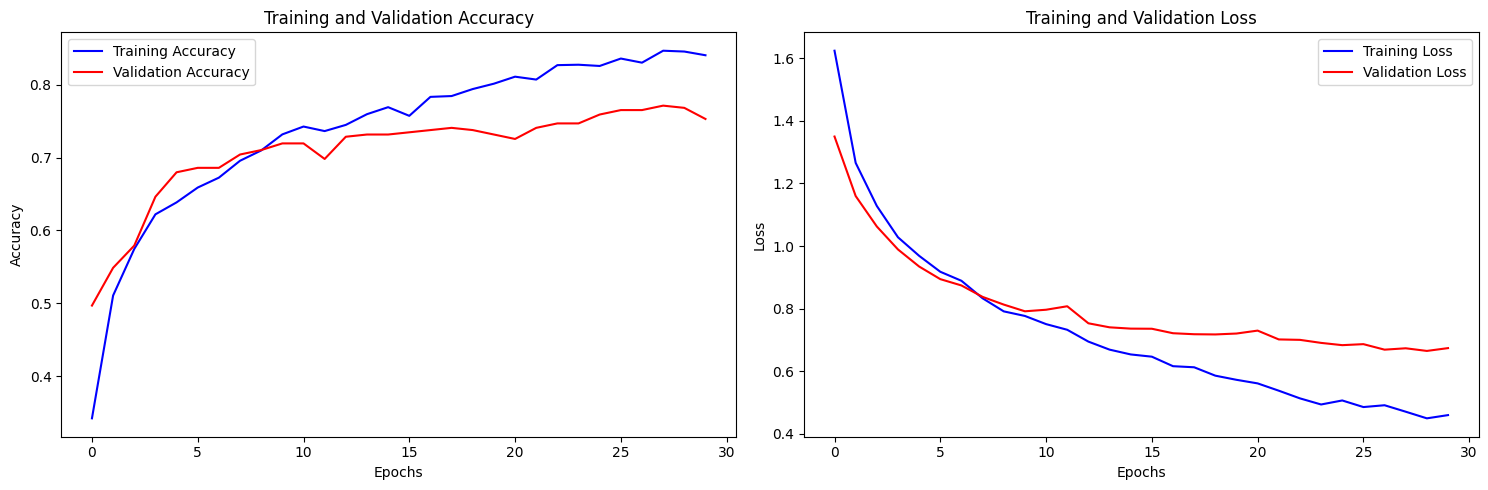

Training Accuracy: 0.8404977321624756
Validation Accuracy: 0.7530487775802612
Training Loss: 0.45976531505584717
Validation Loss: 0.6738709807395935


In [12]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Saving the model
model.save('vgg_model_de.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, roc_curve, auc,
    classification_report, confusion_matrix
)

def evaluate_model(predictions, y_true, class_names):
    # F1 Score
    f1 = f1_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("F1 Score: ", f1)

    # Precision
    precision = precision_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("Precision: ", precision)

    # Recall
    recall = recall_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("Recall: ", recall)

    # Accuracy
    accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1))
    print("Accuracy: ", accuracy)

    # Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1))

    # Plot ROC + Confusion Matrix in one figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # ROC Curve Plot
    for i in range(len(class_names)):
        axes[0].plot(fpr[i], tpr[i], label=class_names[i] + f' (AUC = {roc_auc[i]:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()

    # Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print(classification_report(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), target_names=class_names))



Loading the model



Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.7250 - loss: 0.7485
Test Loss: 0.7783652544021606
Test Accuracy: 0.7215777039527893
F1 Score:  0.7111838939824761
Precision:  0.7223563480832558
Recall:  0.7215777262180975
Accuracy:  0.7215777262180975


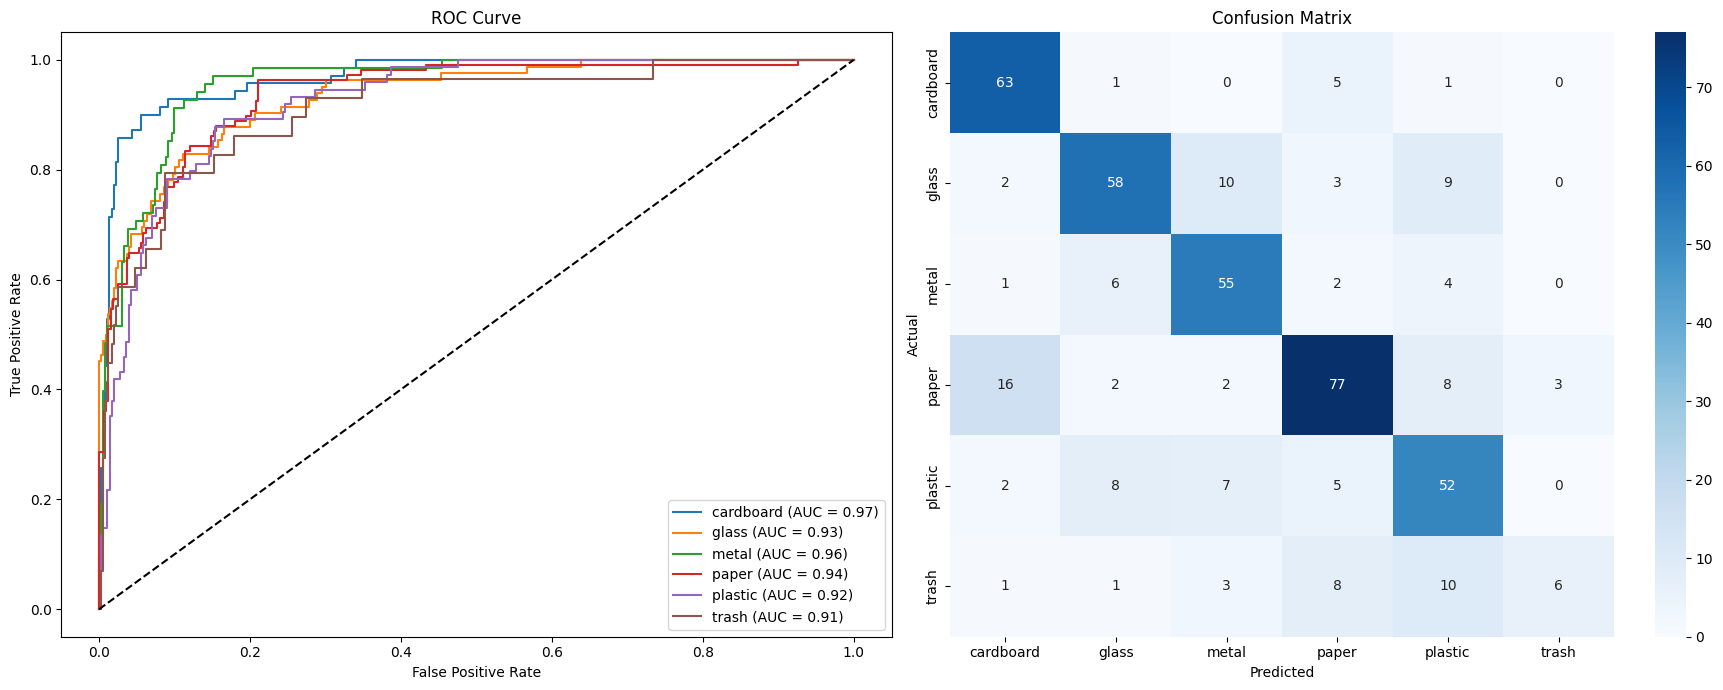

              precision    recall  f1-score   support

   cardboard       0.74      0.90      0.81        70
       glass       0.76      0.71      0.73        82
       metal       0.71      0.81      0.76        68
       paper       0.77      0.71      0.74       108
     plastic       0.62      0.70      0.66        74
       trash       0.67      0.21      0.32        29

    accuracy                           0.72       431
   macro avg       0.71      0.67      0.67       431
weighted avg       0.72      0.72      0.71       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 719ms/step - accuracy: 0.7882 - loss: 0.7858
Test Loss: 0.8404673337936401
Test Accuracy: 0.7633410692214966
F1 Score:  0.7584208627883388
Precision:  0.761995940667841
Recall:  0.7633410672853829
Accuracy:  0.7633410672853829


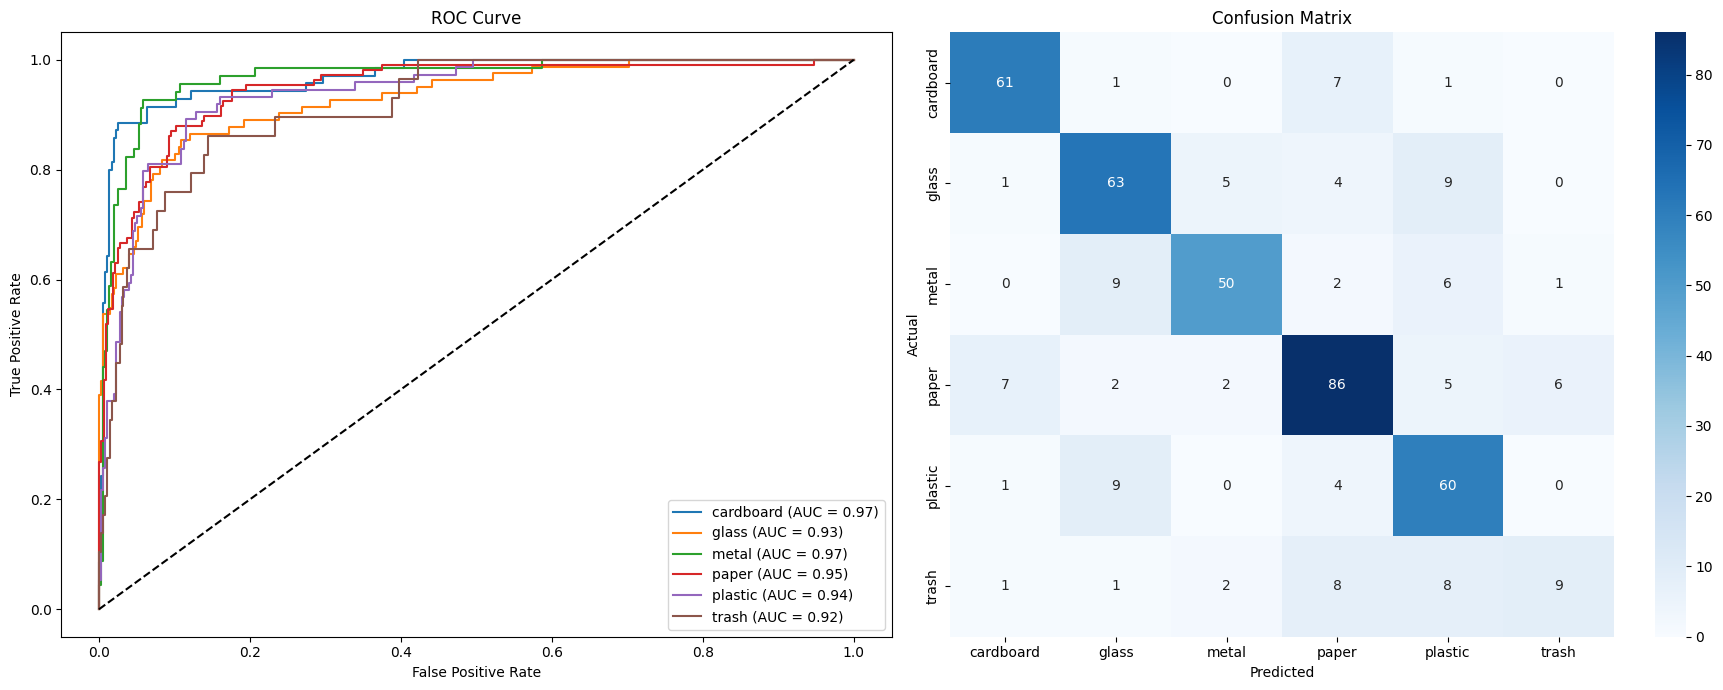

              precision    recall  f1-score   support

   cardboard       0.86      0.87      0.87        70
       glass       0.74      0.77      0.75        82
       metal       0.85      0.74      0.79        68
       paper       0.77      0.80      0.79       108
     plastic       0.67      0.81      0.74        74
       trash       0.56      0.31      0.40        29

    accuracy                           0.76       431
   macro avg       0.74      0.72      0.72       431
weighted avg       0.76      0.76      0.76       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 728ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 726ms/step - accuracy: 0.6990 - loss: 1.0706
Test Loss: 1.0797125101089478
Test Accuracy: 0.6937354803085327
F1 Score:  0.6887373421152938
Precision:  0.7039315682952727
Recall:  0.6937354988399071
Accuracy:  0.6937354988399071


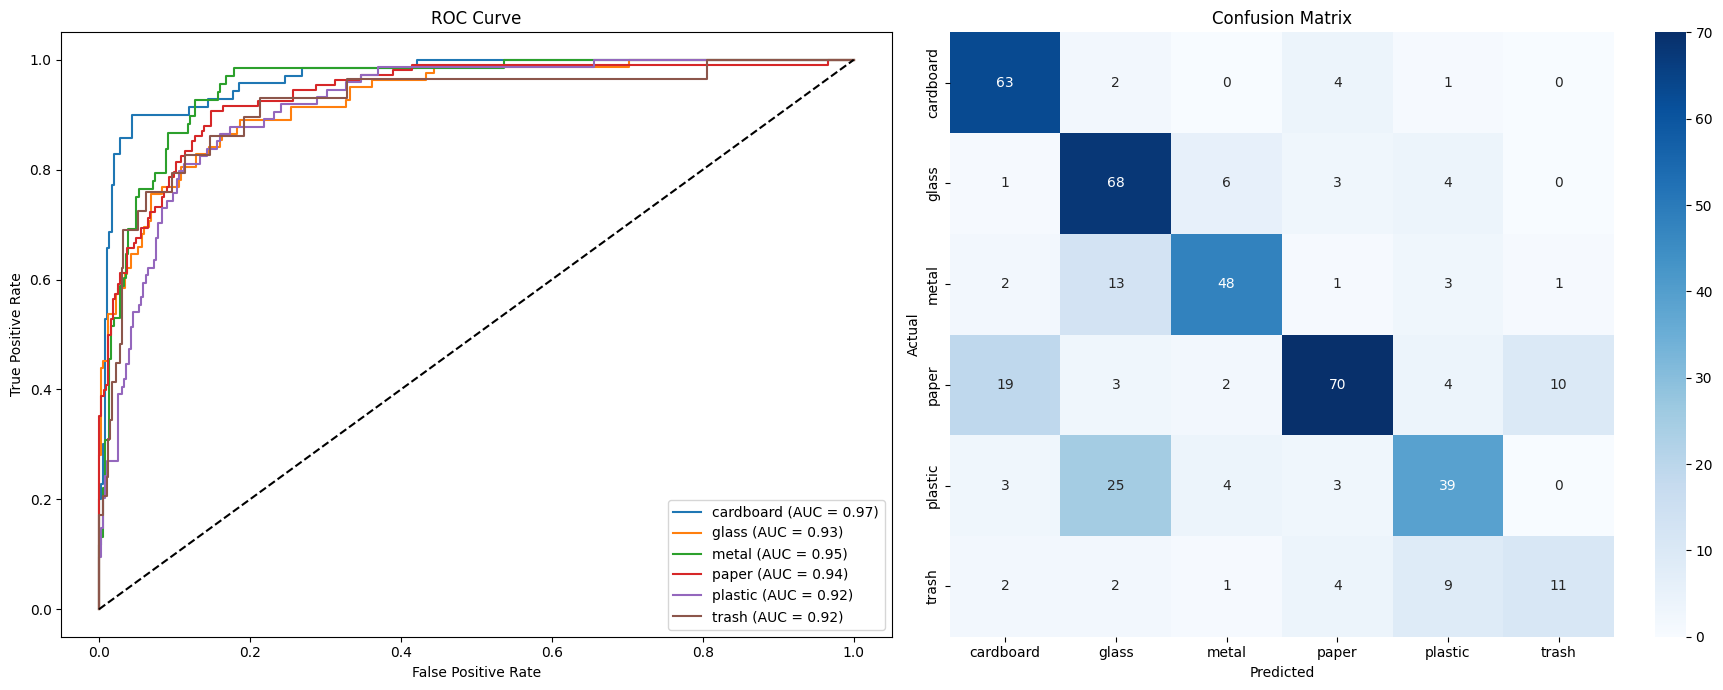

              precision    recall  f1-score   support

   cardboard       0.70      0.90      0.79        70
       glass       0.60      0.83      0.70        82
       metal       0.79      0.71      0.74        68
       paper       0.82      0.65      0.73       108
     plastic       0.65      0.53      0.58        74
       trash       0.50      0.38      0.43        29

    accuracy                           0.69       431
   macro avg       0.68      0.66      0.66       431
weighted avg       0.70      0.69      0.69       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 0.7927 - loss: 0.6172
Test Loss: 0.6617687940597534
Test Accuracy: 0.7633410692214966
F1 Score:  0.760881766218064
Precision:  0.7632877741145918
Recall:  0.7633410672853829
Accuracy:  0.7633410672853829


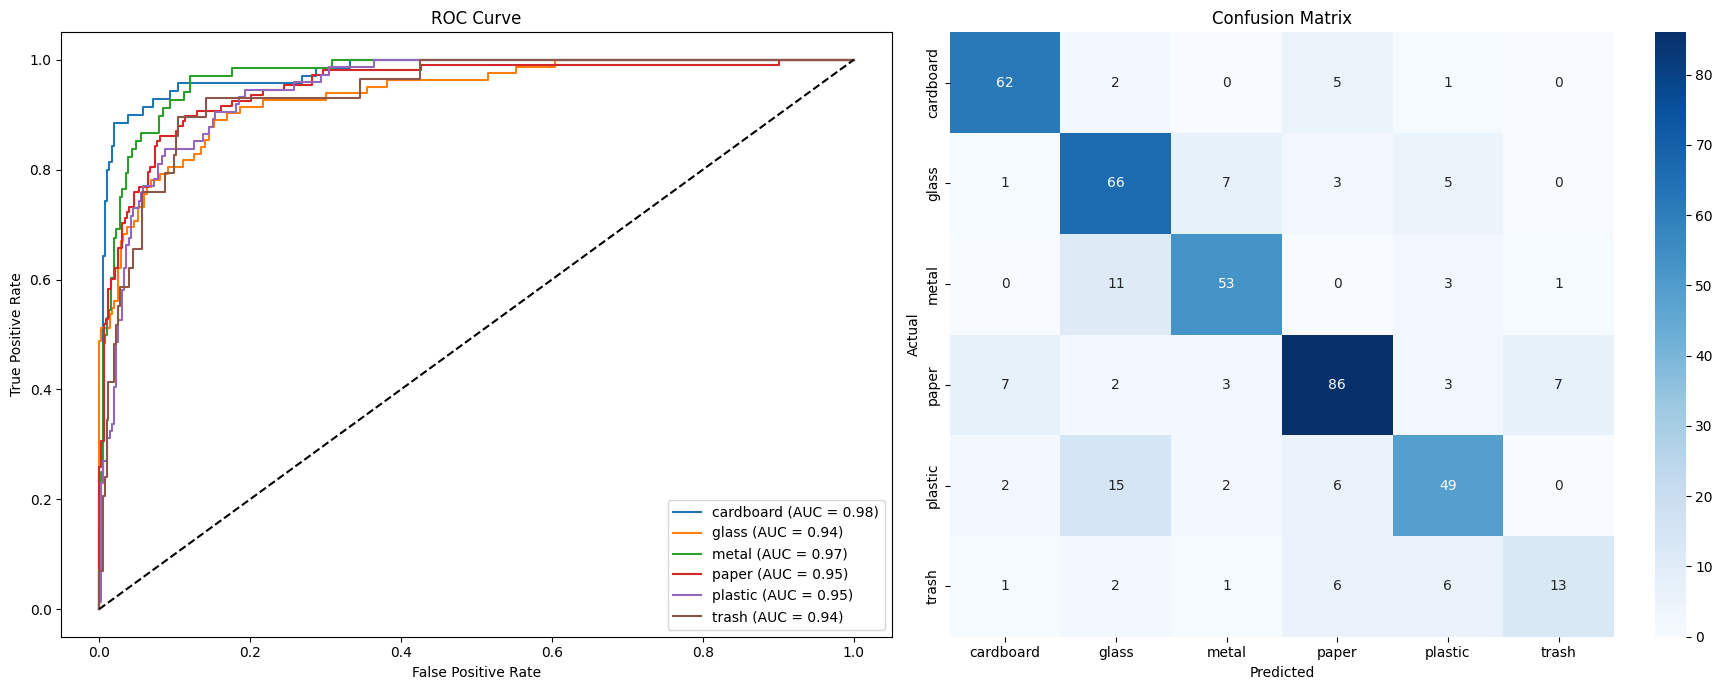

              precision    recall  f1-score   support

   cardboard       0.85      0.89      0.87        70
       glass       0.67      0.80      0.73        82
       metal       0.80      0.78      0.79        68
       paper       0.81      0.80      0.80       108
     plastic       0.73      0.66      0.70        74
       trash       0.62      0.45      0.52        29

    accuracy                           0.76       431
   macro avg       0.75      0.73      0.74       431
weighted avg       0.76      0.76      0.76       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 716ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step - accuracy: 0.8129 - loss: 0.6577
Test Loss: 0.7205202579498291
Test Accuracy: 0.7656612396240234
F1 Score:  0.7560354747853775
Precision:  0.7628951348002615
Recall:  0.765661252900232
Accuracy:  0.765661252900232


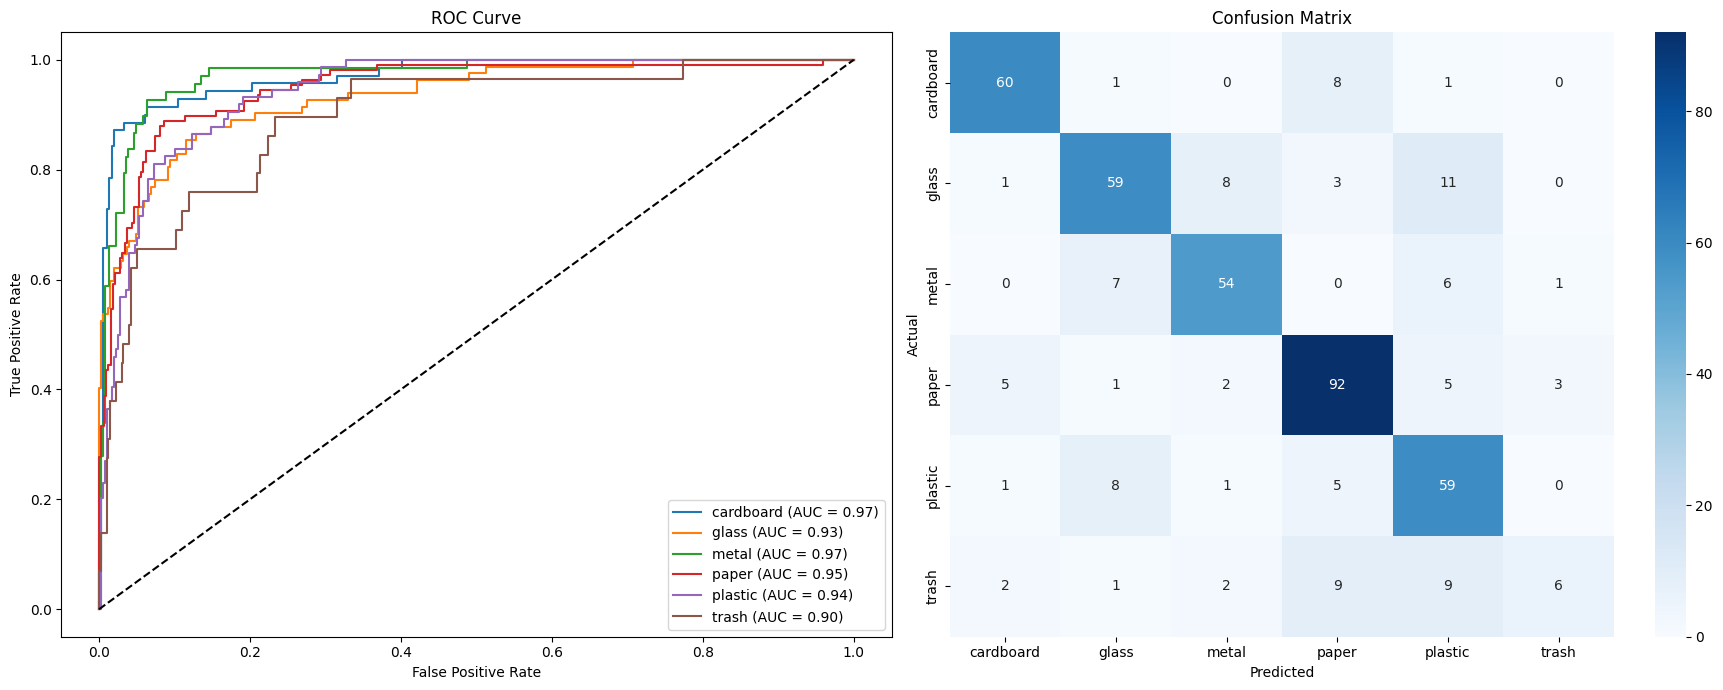

              precision    recall  f1-score   support

   cardboard       0.87      0.86      0.86        70
       glass       0.77      0.72      0.74        82
       metal       0.81      0.79      0.80        68
       paper       0.79      0.85      0.82       108
     plastic       0.65      0.80      0.72        74
       trash       0.60      0.21      0.31        29

    accuracy                           0.77       431
   macro avg       0.75      0.70      0.71       431
weighted avg       0.76      0.77      0.76       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 719ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 714ms/step - accuracy: 0.8221 - loss: 0.5775
Test Loss: 0.672279953956604
Test Accuracy: 0.7749419808387756
F1 Score:  0.762728071539672
Precision:  0.7701384949858182
Recall:  0.7749419953596288
Accuracy:  0.7749419953596288


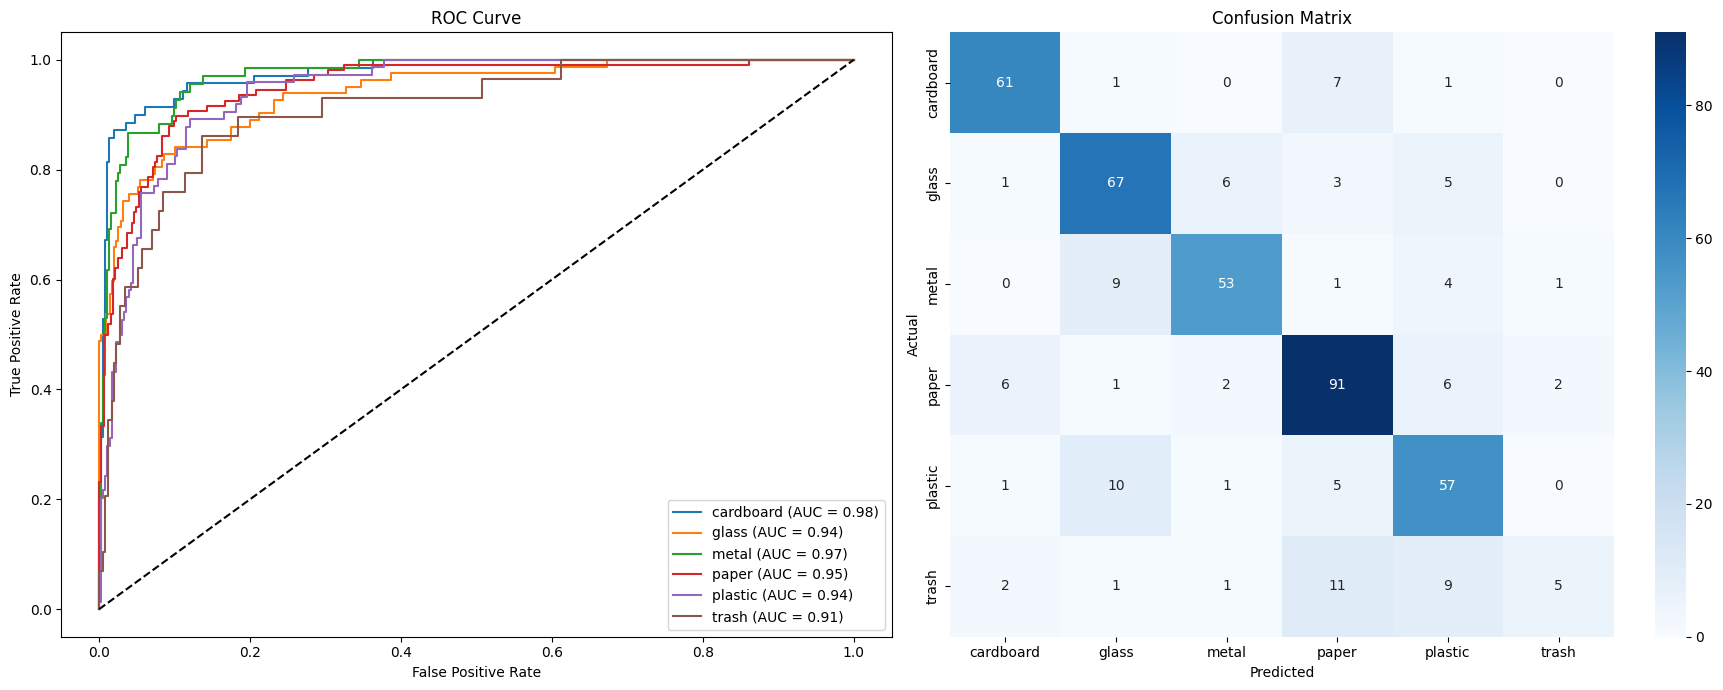

              precision    recall  f1-score   support

   cardboard       0.86      0.87      0.87        70
       glass       0.75      0.82      0.78        82
       metal       0.84      0.78      0.81        68
       paper       0.77      0.84      0.81       108
     plastic       0.70      0.77      0.73        74
       trash       0.62      0.17      0.27        29

    accuracy                           0.77       431
   macro avg       0.76      0.71      0.71       431
weighted avg       0.77      0.77      0.76       431



In [14]:
from keras.models import load_model

print("\nLoading the model")
model = load_model('vgg_model.h5')
model_l2 = load_model('vgg_model_l2.h5')
model_l1 = load_model('vgg_model_l1.h5')
model_dropout = load_model('vgg_model_dropout.h5')
model_es = load_model('vgg_model_es.h5')
model_de = load_model('vgg_model_de.h5')

for m in [model, model_l2, model_l1, model_dropout, model_es, model_de]:
    print("\nEvaluating the model")
    predictions = m.predict(X_test)
    loss, accuracy = m.evaluate(X_test, y_test)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    evaluate_model(predictions, y_test, classes_names)